In [ ]:
#공유 드라이브 연결
from google.colab import drive
import os
drive.mount('/content/gdrive/', force_remount=True)
os.chdir('gdrive/MyDrive/DoVie/Week3 Transformer/')

Mounted at /content/gdrive/


In [ ]:
from torch import Tensor
import torch
from torch import nn
import torch.nn.functional as f
import math
import matplotlib.pyplot as plt

### **Transformer에 들어가기 전에**

작성자 : 도진우

일시 : 2021년 03월 26일
Transformer에서 다룰 예제는 Pytorch Tutorial에 올라와 있는 예제와 '딥러닝 자연어 처리 입문'에 나와있는 개념들을 구현하는 방식으로 진행하겠습니다.

참고 자료  
- https://tutorials.pytorch.kr/beginner/transformer_tutorial.html
- https://wikidocs.net/31379
- https://medium.com/the-dl/transformers-from-scratch-in-pytorch-8777e346ca51

##1. Transformer가 나온 배경

1) Seq2Seq와 한계
- 우리는 Seq2Seq를 공부하며, 인코더-디코더 구조에 대해서 배웠습니다. 해당 구조에서는 인코더에서 RNN을 구현해 입력을 받아 하나의 context vector로 요약을 하고, 요약된 정보를 디코더의 hidden_state의 초깃값으로 사용합니다.

- 하지만, 이러한 접근 방식은 고정된 vector안에 인풋으로 받은 정보들을 모두 요약해야 하기 때문에, 인풋의 길이가 길어질수록 정보가 소실되는 현상이 발생합니다.

- 그래서 나온 개념이 Attention 개념을 RNN에 적용하는 것입니다.

2) Attention을 이용한 RNN과 한계
- Attention을 이용하면, 디코더의 각 시점(t시점) 마다 어떠한 부분이 해당 시점에서 중요한지(Encoder output의 state가 현재 decoder의 hidden_state와 유사한지)를 추출해 다음 단어를 예측하는 데 도움을 줍니다. 매 t 시점마다 Attention 연산이 진행되므로 인풋이 길어질수록 정보가 소실되는 현상을 해결할 수 있었습니다. 

- 이러한 연산 방식은 시간이 많이 소요됩니다. 기본적으로 RNN이 시간이 많이 소요되는 네트워크(autoregressive model) 이므로, 시간이 많이 소요되는 RNN을 제거하여 시간을 단축하면서도 성능은 떨어지지 않는 모델을 만들 순 없을까요??

3) Tranformer의 등장
- 위의 단점들을 보완한 것이 Transformer입니다. Transformer는 RNN을 사용하지 않고, Attention 기법과 행렬 연산을 통해 비슷한 성능을 내는 모델입니다. Transformer를 처음 소개한 논문 제목은 'Attention Is all you need'로써 위와 같은 특징을 잘 반영합니다. 이제 예시와 함께 Tutorial을 진행해 보겠습니다.

## 2. Transformer

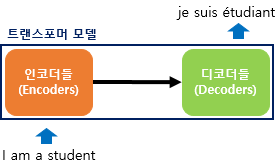

트랜스포머는 RNN을 사용하지는 않지만, 기존의 Seq2Seq처럼 인코더에서 입력 시퀀스를 입력받고, 디코더에서 출력 시퀀스를 출력하는 인코더-디코더 구조를 유지하고 있습니다.

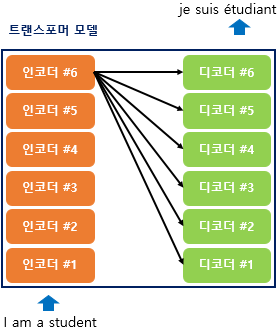

위 그림은 인코더와 디코더가 6개씩 존재하는 트랜스포머의 구조입니다. 

### Transformer 하이퍼파라미터

실습에 필요한 파라미터를 사전에 정의하겠습니다.

dim_model = 512
- 트랜스포머의 인코더와 디코더에서 정해진 입력과 출력의 크기를 의미합니다. 임베딕 벡터의 차원과, Positional encoding vector의 차원과 동일합니다.

num_layers = 6
- 인코더와 디코더가 총 몇 층으로 구성되었는지에 대한 파라미터 입니다.

num_heads = 8
- 트랜스포머에서는 어텐션을 사용할 때, Multi-head Attention을 사용하여 병렬처리를 하는데 이 때, 병렬의 개수를 의미합니다.

d_ff = 2048
- 트랜스포머 내부에는 피드 포워드 신경망이 존재합니다. 이때 은닉츠으이 크기를 의미합니다. 피드 포워드 신경망의 입력층과 출력층의 크기는 dim_model입니다.

## 3. 포지셔널 인코딩

Attention을 활용한 RNN에서는 단어의 위치에 따라 순차적으로 데이터를 입력받으므로(각 시점에 하나씩 단어가 들어감) 각 단어의 위치 정보를 가질 수 있습니다. 

하지만 트랜스포머는 단어 입력을 순차적으로 받는 방식이 아니라 한번에 입력받기 때문에 단어의 위치정보를 다른 방법을 통해 알려주어야 합니다. 이를 위해 각 단어의 임베딩 벡터 + Positional Encoding을 통해 위치정보를 알려주게 됩니다.

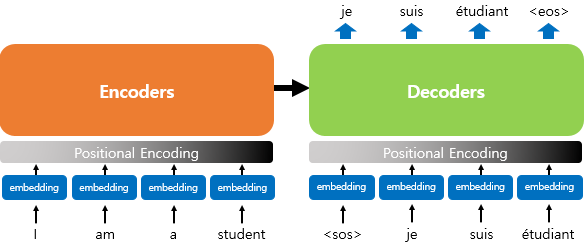

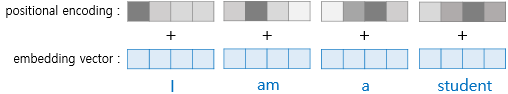



위의 그림처럼 각 단어들의 Embedding vector와 Positional encoding vector를 더해서 위치 정보를 포함한 벡터를 만들어 줍니다.

Positional encoding vector를 만드는 방법은 아래의 식에 따라 만듭니다.

pos는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, i는 임베딩 벡터 내의 차원 인덱스를 의미합니다.



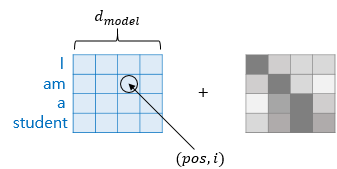

$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{model}})$      (i가 짝수인 경우)

$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{model}})$  (i가 홀수인 경우)


In [ ]:
class PositionalEncoding(nn.Module):
  #계산 구조 정의.
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #2차원 배열 만들기, Position은 Seq_len만큼의 배열 크기를 들고 있어야한다.
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term) #짝수는 sin함수
        pe[:, 1::2] = torch.cos(position * div_term) #홀수는 cos함수
        pe = pe.unsqueeze(0).transpose(0, 1) #차원 줄인후, transpose
        self.register_buffer('pe', pe) #Optimizer가 업데이트하지 않지만, GPU 연산 가능.

    def forward(self, x):
      x = x + self.pe[:x.size(0), :] 
      return self.dropout(x)

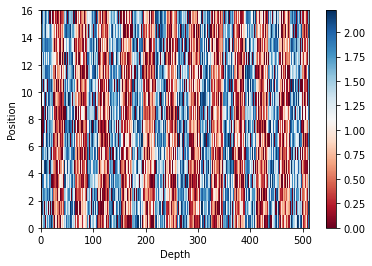

In [ ]:
max_len = 50
d_model = 512
d_seq = 16

Pos = PositionalEncoding(d_model = d_model, max_len = max_len)
pe = Pos(torch.rand(d_seq,d_model))
plt.pcolormesh(pe.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()

##4. Attention
위의 포지셔널 인코딩 작업을 끝마친, 벡터는 이제 인코더에 들어가야합니다. 인코더와 디코더에는 Attention 연산이 포함되어 있는데, 본격적으로 들어가기 전 트랜스포머에서 사용되는 세 가지 어텐션을 정리해봅시다.

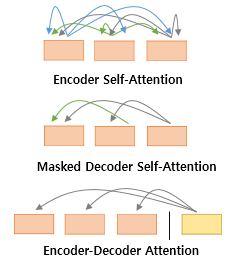

첫 번째 그림과 두 번째 그림의 어텐션은 셀프 어텐션(self-attention)이라고 합니다. 셀프 어텐션은 Query, Key, Value가 같은 벡터의 출처를 가짐을 의미합니다.  이에 반해, 세 번째 어텐션은 Q : 디코더 벡터, K, V : 인코더 벡터를 사용하여 셀프 어텐션이라고 부르지 않습니다.

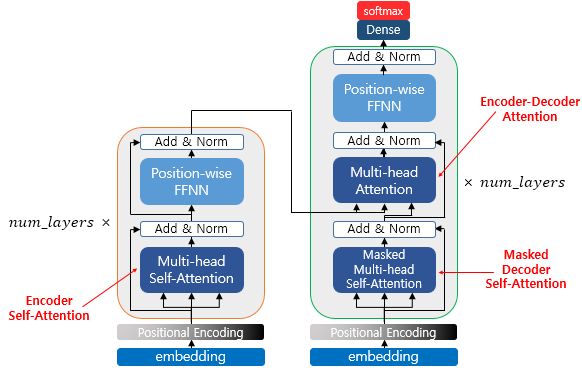

##5. 인코더
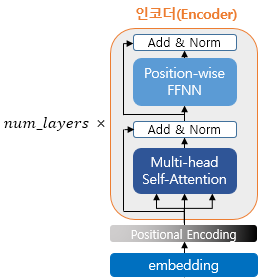

인코더의 구조는 위의 그림과 같습니다. 인코더는 크게 두 개의 sublayer로 구성되어 있습니다. 대략적으로 설명드리면, 포지셔널 인코딩이 된 벡터가 인풋으로 들어와 Multi-head self-Attention(어텐션 병렬처리)을 수행합니다. 그 값은 다시 정규화 과정인 Add & Norm 거치고 그 결과 값은 피드포워드 신경망으로 들어가게 됩니다. 최종적으로 피드포워드 신경망의 output과 그 이전 Add & Norm 과정의 output이 더해져 다시 Add & Norm 과정을 거칩니다. 

트랜스포머는 인코더를 쌓는 구조이기 때문에, 위와 같은 구조의 인코더들이 N개씩 쌓여있습니다. 

이제 좀 더, 인코더에서 사용되는 self-attention과 multi-head attention에 대해서 자세히 알아보겠습니다.



### 5.1. Self attention의 의미와 이점
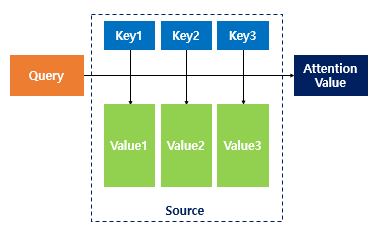

어텐션 함수의 기본적인 메커니즘은 쿼리(Q)에 대해서 모든 키(K)와의 유사도를 각각 구합니다. 그리고 구해낸 이 유사도를 가중치로 하여 키와 맵핑되어 있는 각각에 값(V)에 반영해줍니다. 그리고 유사도가 반영된 값(V)를 모두 가중합하여 리턴합니다. 


여기까지가 우리가 지금까지 사용해온 기본적인 Attention 메커니즘입니다. 셀프 어텐션에 대해 제대로 이해하기 위해 RNN에서 사용되던 Attention 메커니즘을 다시 보겠습니다. 

- Q = Query : t 시점의 디코더 셀에서의 은닉 상태
- K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
- V = Values : 모든 시점의 인코더 셀의 은닉 상태들

RNN에서 사용되는 Attention의 경우 t 시점마다 연산이 일어나게 되는데 이것은 결국 시점마다의 반복 연산이므로 전체 연산으로 일반화가 가능합니다. 이를 전체 연산으로 일반화한 식은 다음과 같습니다.

- Q = Querys : 모든 시점의 디코더 셀에서의 은닉 상태들
- K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
- V = Values : 모든 시점의 인코더 셀의 은닉 상태들


Transformer에는 RNN 구조가 없기 때문에, Attention을 시점마다 처리하는 것이 아니라 한 번에 모든 Vector에 대한 Attention을 해야할 것입니다. 그래서 트랜스포머의 셀프 어텐션에에서의 Q, K, V는 아래와 같습니다.

- Q : 입력 문장의 모든 단어 벡터들
- K : 입력 문장의 모든 단어 벡터들
- V : 입력 문장의 모든 단어 벡터들

위의 Q,K,V를 통해 RNN에서 사용되는 t 시점을 없앴으며, 각 Q,K,V의 출처는 모두 동일합니다. 이를 self-attention이라고 합니다. 

self-attention의 효과를 살펴봅시다.

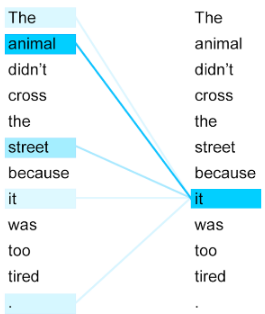

위의 예시 문장을 번역하면 '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다'입니다. 그런데 여기서 '그것'은 동물일까요? 길일까요? 사람은 쉽게 이것이 동물이라는 것을 알아차릴수 있지만, 컴퓨터는 이것을 이해하기 힘듭니다. 이를 이해시키기 위해 셀프어텐션을 사용하는데, 입력 문장 내의 단어들끼리의 유사도를 구함으로써 '그것'이 '동물'과 연관되었을 확률이 높다는 것을 찾아냅니다.

### 5.2. Q,K,V 벡터 

위에서 self-attention에 사용되는 Q,K,V는 입력 문장의 모든 단어 벡터라고 하였습니다. 사실 인코더의 초기 입력인 d_model 차원의 단어 벡터들을 사용하여 셀프 어텐션을 수행하는 것이 아니라, 각 단어들로부터 Q벡터, K벡터, V벡터를 얻는 작업을 거칩니다. 이때 Q,K,V 벡터들은 초기 입력인 d_model 차원보다 더 작은 차원을 가집니다. 논문에서는 d_model = 512 임에 반해, Q,K,V벡터는 64 차원입니다.

이러한 이유는 Multi-head attention에 있습니다. d_model의 차원의 임베딩 벡터로 Q,K,V를 구성하는 것이 아닌, 여러개의 더 작은 벡터로 구성해 그것들을 병렬연산을 하여 더욱 다양한 각도에서 보고자 하는 것입니다. 이는 뒤에 나오는 Multi-head Attention에서 더 자세히 설명하겠습니다. 

64라는 값은 트랜스포머의 하이퍼파라미터인 num_heads로 인해 결정됩니다. d_model / num_heads 로 Q,K,V 벡터의 차원을 결정하며, num_heads의 개수만큼 병렬처리합니다. 아래의 예시처럼 각 단어에 대해 Q,K,V
벡터를 얻습니다.

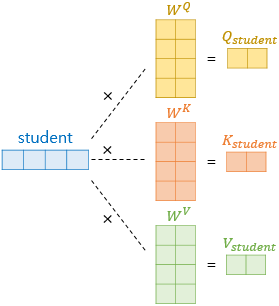


### 5.3. 스케일드 닷-프로덕트 어텐션

Q,K,V 벡터를 얻었다면 Attention을 연산을 진행할 수 있습니다. 해당 과정은 이제까지 배웠던 과정과 같습니다.

- 각 단어인 Query와 K를 닷-프로덕트 한 값을 $\sqrt{d_k}$ 로 나누어  Attention Score를 구한다. 
- Attention Score에 Softmax 함수를 거쳐서 Attention Disribution을 구한다.
- Attention Distribution을 V 벡터에 가중합하여 Attention Value를 구한다.

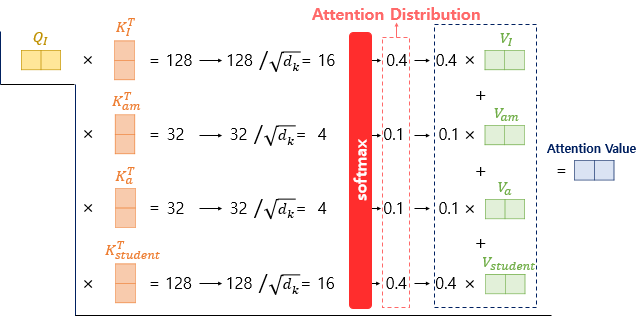



### 5.4. 행렬 연산으로 일괄 처리하기

위와 같은 연산을 각 하나의 단어마다 처리할 필요 없이 행렬으로 한방에 처리할 수 있으며, 실제로도 행렬처리 합니다.

이를 행렬로 이해하면, 포지셔널 인코딩을 거친 단어 벡터들이 들어와서 이들을 대상으로 Q,K,V의 행렬을 구합니다.
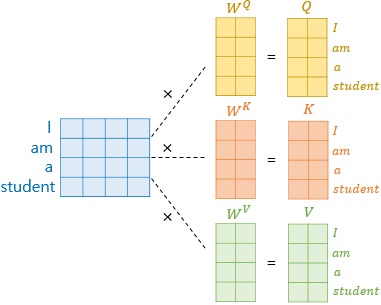

이렇게 구한 Q,K,V 행렬을 가지고 Attention 연산 과정을 수행합니다. 식은 아래와 같습니다.

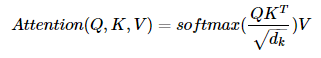

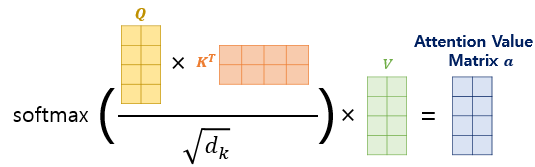

이렇게 해서 최종 Attention Value matrix는 (Seq_len,d_model / num_heads)의 형태를 가집니다.

이제 구현을 해봅시다. 

In [ ]:
class AttentionHead(nn.Module):
  def __init__(self, dim_in: int, dim_k: int, dim_v: int, mask = None):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_k)
        self.k = nn.Linear(dim_in, dim_k)
        self.v = nn.Linear(dim_in, dim_v)
        self.mask = mask
        
  def scaled_dot_product_attention(query, key, value, mask = None):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)  
    
    # dot - product하기.
    matmul_qk = torch.bmm(query,key.transpose(1,2)) 
    #값 스케일링 하기, dk의 루트값으로 나눠준다.
    depth = key.shape[-1]
    logits = matmul_qk / math.sqrt(depth)
    #마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수 값을 넣는다.
    if mask is not None:
      logits += (mask * -1e9)
    # 소프트맥수 함수. 마지막 차원인 key의 문장 길이 방향으로 수행된다. 
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = f.softmax(logits, dim=-1)
    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = torch.bmm(attention_weights, value)
    return output

  def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:    
    return self.scaled_dot_product_attention(self.q(query), self.k(key), self.v(value), self.mask)

In [ ]:
q = nn.Linear(512, 64)
temp_q = torch.rand(10,6,512)
t_q = q(temp_q)

In [ ]:
temp_q = torch.rand(10,6,64)
temp_k = torch.rand(10,6,64)
temp_v = torch.rand(10,6,64)
temp_q.shape[1]

#attn = AttentionHead(512, 64, 64)

#temp = attn(temp_q,temp_k,temp_v)

6

In [ ]:
AttentionHead

AttributeError: ignored

In [ ]:
temp_q = torch.rand(10,6,64)

In [ ]:
temp_q.shape

torch.Size([10, 6, 64])

### 5.4 멀티 헤드 어텐션(Multi-head Attention)

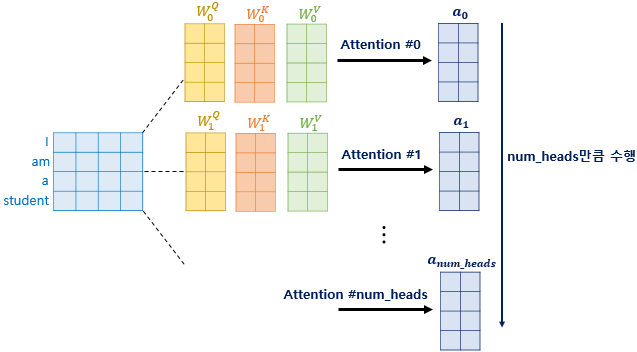

- 어텐션에서 d_model의 차원을 가진 vector를 num_heads로 나눈 차원을 가진 Q,K,V로 변환 후 어텐션을 수행했습니다. 즉, 논문 기준으로 512인 d_model을 num_heads = 8로 나누어 64 vector인 Q,K,V로 어텐션을 수행한 셈입니다. 이렇게 학습할 때, 가중치 파라미터인 W_q, W_k, W_v 역시 8개의 행렬이 생기게 되고, 각자 다른 값으로 업데이트 됩니다. 

- 트랜스포머 연구진은 이렇게 여러번의 어텐션을 병렬로 사용하는 것이, 한 번의 어텐션을 하는 것보다 효과적이라고 말하였습니다. 이 이유는 무엇일까요?? 그리스로마 신화의 머리가 여러 개인 괴물 히드라나 케로베로스는 머리가 여러 개 달려있어서 여러 시각에서 주위를 살필 수 있습니다. 이러한 것처럼 트랜스포머에서도 데이터를 다 다른 가중치 파라미터를 통해 다양한 시각에서 정보를 수집하겠다는 것입니다. 

- 앞에 설명한 예 중 '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다'를 예로 들겠습니다. 이 문장을 병렬 어텐션을 사용하여 어텐션을 적용할 때, 어떤 어텐션층의 결과 값으로는 그것을 길이라고도 해석할 것이고, 어떤 어텐션층의 결과는 그것을 동물이라고도 해석할 것입니다. 트랜스포머는 데이터를 다양한 시각으로 볼 수 있는 효과가 있습니다. 

- 이제 병렬 어텐션의 출력 값들을 어떻게 하나의 값으로 모으는 지 알아봅시다. 

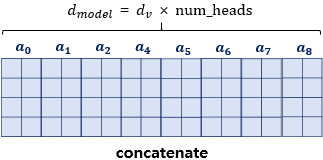


- 병렬 어텐션을 수행한 후, 각 결과 값을 모두 concat합니다. 그래서 결국 연결된 어텐션 헤드 행렬의 크기는 (seq_len, d_model)이 됩니다.

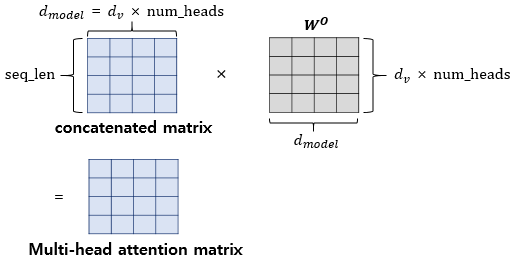

- 이렇게 concat된 행렬에는 W_0라는 가중치 행렬을 곱하게 되는데, 이것이 최종 멀티-헤드 어텐션의 결과물입니다. 결과물 행렬의 크기는 처음 인코더의 인풋 데이터의 크기와 똑같이 (seq_len, d_model)로 동일합니다. 

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads: int, dim_in: int, dim_k: int, dim_v: int):
      super().__init__()
      #num_heads 수 만큼의 AttentionHead 개수.
      self.heads = nn.ModuleList(
          [AttentionHead(dim_in, dim_k, dim_v) for _ in range(num_heads)]
      )
      #최종 Linear 층.
      self.linear = nn.Linear(num_heads * dim_v, dim_in)

  def forward(self, query: Tensor, key: Tensor, value: Tensor) -> Tensor:
    #각 AttentionHead에 query, key, value 값을 넣어준다. 그리고 결과 값을 concat해서 linear층에 넣어준다. 
    return self.linear(torch.cat([h(query, key, value) for h in self.heads], dim=-1))

### 5.5 포지션-와이즈 피드 포워드 신경망(Position-wise FFNN)

피드 포워드 신경망은 인코더, 디코더에서 공통적으로 가지고 있는 층입니다.


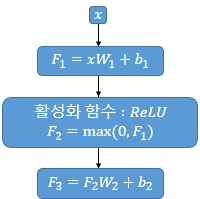


- 여기서 x는 멀티 헤드 어텐션의 결과로 나온 (seq_len, d_model)의 크기를 가지는 행렬을 말합니다. 가중치 행렬 W_1은 (d_moel, d_ff)의 크기를 가지고, 가중치 행렬 W_2는 (d_ff, d_model)의 크기를 가집니다. 논문에서 은닉층의 크기인 d_ff는 앞서 하이퍼파라미터를 정의할 때 언급했듯이 2,048의 크기를 가집니다. 
- 여기서 매개변수 W_1, b_1, W_2, b_2는 하나의 인코더 층 내에서는 다른 문장, 다른 단어들마다 정확하게 동일하게 사용되지만, 인코더 층마다는 다른 값을 가집니다. 





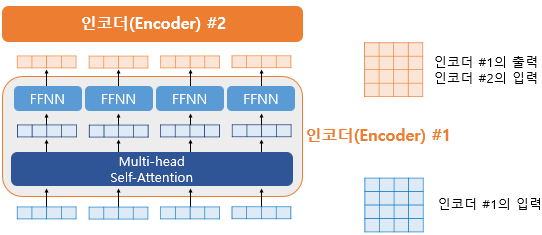

- 위의 그림은 FFNN층을 통과하는 모습을 보여주는데, FFNN층의 출력은 입력의 크기와 동일한 (seq_len, d_model)임을 알 수 있습니다. 

### 6. 잔차 연결(Residual connection)과 층 정규화(Layer Normalization)


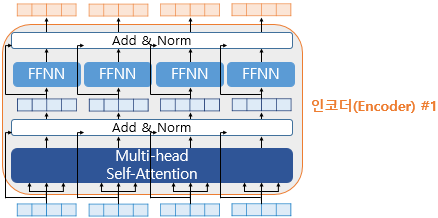




Add & Norm은 위의 그림과 한 인코더에서 같이 두 번 거치는 과정입니다. 화살표들을 잘 보면, 서브층 이전의 입력과 서브층 출력이 동시에 들어가는 것을 볼 수 있는데 이러한 이유를 알아봅시다. 


#### 6.1. 잔차 연결(Residual connection)

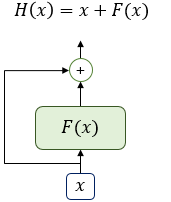

- 위 그림은 입력 x에 대해 x와 F(x) 함수를 더한 값을 출력하는 함수 H(x)를 구현한 것입니다. 잔차 연결 함수 H(x)는 컴퓨터 비전 분야에서 주로 사용되는 모델의 학습을 돕는 기법입니다. 이를 식으로 표현하면 x + Sublayer(x)라고 할 수 있습니다. 


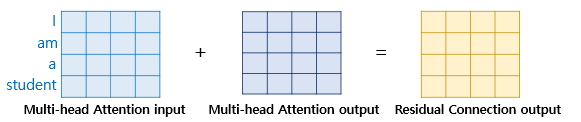


#### 6.2. 층 정규화(Layer Normalization)




- 잔차 연결을 거친 결과는 이어서 층 정규화 과정을 거칩니다. 잔차 연결의 입력을 x, 잔차 연결과 층 정규화 두 가지 연산을 모두 수행한 후의 결과를 N이라고 할 때, 잔차 연결 후 층 정규화 연산을 수식으로 표현하면 다음과 같습니다.

N = LayerNorm(x + Sublayer(x))

층 정규화란?
- 층 정규화는 **텐서의 마지막 차원**에 대해서 평균과 분산을 구하고, 이를 가지고 어떤 수식을 통해 값을 정규화하여 학습을 돕는 것입니다. 


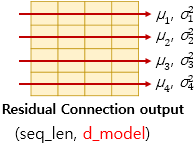

- 우선 화살표 방향으로 평균과 분산을 구합니다.


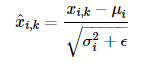


- 그리고 위의 수식을 통해 정규화를 진행해줍니다.
- e(입실론)의 역할은 분모가 0이 되는 것을 방지하는 값입니다. 
- 이제 r(감마)와 b(베타) 값을 준비합니다. 이들의 초기 값은 각각 1과 0입니다.

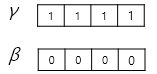


- r와 b를 도입한 층 정규화의 최종 수식은 다음과 같으며, r와 b는 학습 가능한 파라미터입니다.

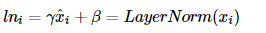

In [ ]:
class Residual(nn.Module):
    def __init__(self, sublayer: nn.Module, dimension: int, dropout: float = 0.1):
        super().__init__()
        self.sublayer = sublayer
        self.norm = nn.LayerNorm(dimension)  #Norm 계층
        self.dropout = nn.Dropout(dropout)   #Dropoutp 계층

    def forward(self, *tensors: Tensor) -> Tensor:
        # Assume that the "value" tensor is given last, so we can compute the
        # residual.  This matches the signature of 'MultiHeadAttention'.
        return self.norm(tensors[-1] + self.dropout(self.sublayer(*tensors)))

torch.Size([10, 6, 6])

### 인코더 쌓기

- 앞에서 배운 내용들을 토대로 인코더를 쌓아서 완성해봅시다.


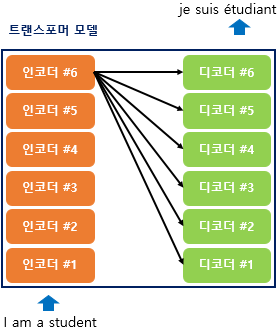

In [ ]:
#하나의 인코더 Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self, 
        dim_model: int = 512, 
        num_heads: int = 6, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
    ):
        super(TransformerEncoderLayer, self).__init__()
        dim_k = dim_v = dim_model // num_heads
        
        self.attention = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_k, dim_v),
            dimension=dim_model,
            dropout=dropout,
        )

        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, src: Tensor) -> Tensor:
        src = self.attention(src, src, src)
        return self.feed_forward(src)


class TransformerEncoder(nn.Module):
    def __init__(
        self, 
        num_layers: int = 6,
        dim_model: int = 512, 
        num_heads: int = 8, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
    ):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(dim_model, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, src: Tensor) -> Tensor:
        seq_len, dimension = src.size(1), src.size(2)
        src += position_encoding(seq_len, dimension)
        for layer in self.layers:
            src = layer(src)

        return src

NameError: ignored

## 7. 디코더

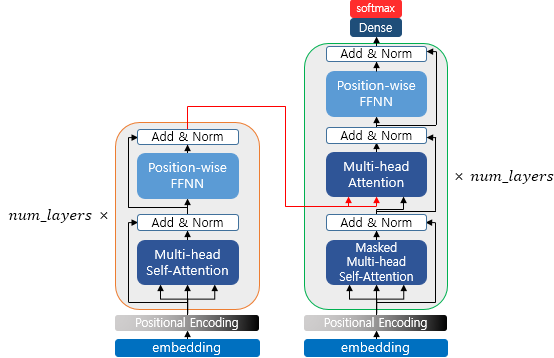

- 이제부터 디코더에 대해서 정의해보겠습니다. 

- 위의 그림은 인코더, 디코더 구조에서 데이터가 어떻게 움직이는지 나타낸 그림입니다.

- 디코더에서는 3개의 sublayer(서브층)이 있습니다. 

- 아래에서 자세히 다루도록 하겠습니다.

### 7.1. 디코더의 첫번째 서브층 : 셀프 어텐션과 룩-어헤드 마스크 


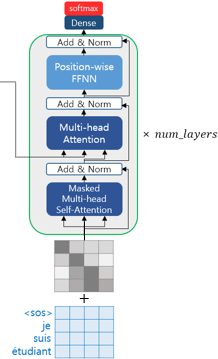

- 디코더에서도 인코더 계층과 같이 학습과정에서는 Teacher Forcing을 사용하여 번역된 문장을 한번에 입력받습니다. 그리고 포지셔널 인코딩을 거친 후, 디코더에 입력됩니다. 

- 그리고 멀티 헤드 어텐션 계층을 거칩니다.

- 하지만 문제가 하나 있습니다. 기존의 RNN 구조에서는 디코더의 각 시점마다 이전 시점에 예측했던 값이 새로운 인풋으로 들어와 데이터가 하나씩 입력되는 구조였지만, 트랜스포머에서는 데이터가 한번에 들어오기 때문에, 미래 시점의 단어까지도 참고할 수 있는 현상이 발생합니다. 즉, 미래를 이미 보고 미래를 예측하는 구조가 되버리는 문제가 발생합니다.

- 이러한 문제를 해결하기 위해 트랜스포머에서는 룩-어헤드 마스크 기법을 사용합니다. 즉, 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 하기 위한 기법입니다. 


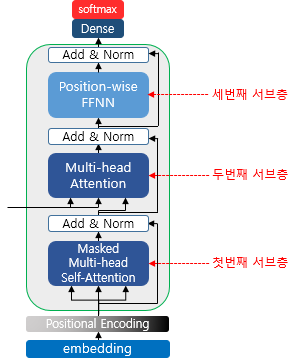


- 룩 어헤드 마스크 기법은 디코더의 첫번째 서브층에서 이루어집니다.





- 기본적으로 Positional Encoding을 거친 벡터 값은 첫번째 서브층으로 들어와서 셀프 어텐션 과정을 수행해서 Attention Score Matrix를 구합니다. 


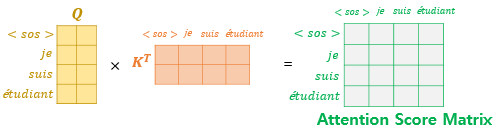


- 이렇게 구한 Attention Score Matrix에 대해 아래의 그림과 같이 마스킹합니다.



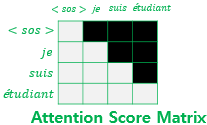


- 행이 현재 시점에서 각 단어와의 유사도를 구한 것이라고 생각하면 됩니다.
- RNN 구조에서도 이전 시점의 단어들을 참고할 수 있었으므로, 위의 그림과 같이 이전에 나온 단어들과의 유사도를 분석하는 것은 그대로 두고, 미래의 단어와의 유사도 분석 부분을 0으로 만들어 Masking처리합니다.

In [ ]:
def _generate_square_subsequent_mask(self, sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

tensor([[[1.0000, 1.5000],
         [1.5000, 2.0000]],

        [[1.5000, 3.0000],
         [3.5000, 4.0000]]])

In [ ]:
import torch

a = torch.ones(1,10)
b = torch.triu(torch.ones(10,5))
b = b.float().masked_fill(b == 0, float('-inf')).masked_fill(b == 1, float(0.0))

In [ ]:
b = torch.triu(torch.ones(5,5))
b

tensor([[1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]])

### 7.2. 디코더의 두번째 서브층 : 인코더-디코더 어텐션

- 디코더의 두 번째 서브층은 멀티 헤드 어텐션을 수행한다는 점에서 이전의 어텐션들과 같지만, 셀프 어텐션은 아닙니다. 

- 인코더-디코더 어텐션은 Query가 디코더인 행렬인 반면, Key와 Value는 인코더 행렬이기 때문입니다. 

- 디코더의 두번째 서브 층을 확대해보면, 다음과 같이 인코더로부터 두 개의 화살표가 그려져 있습니다. 

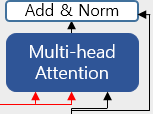

- 두 개의 빨간 화살표는 Key와 Value를 의미하며, 이는 인코더의 마지막 층에서 온 행렬로부터 얻습니다. 반면, Query는 디코더의 첫번째 서브층의 결과로부터 얻습니다. 

- Query가 디코더 행렬, Key가 인코더 행렬일 때, 어텐션 스코어 행렬을 구하는 과정은 아래의 그림과 같습니다. 

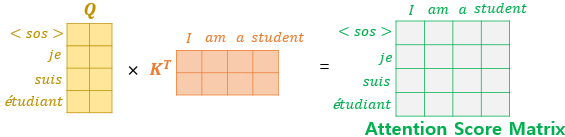

In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(
        self, 
        dim_model: int = 512, 
        num_heads: int = 6, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
    ):
        super().__init__()
        dim_k = dim_v = dim_model // num_heads
        self.attention_1 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_k, dim_v),
            dimension=dim_model,
            dropout=dropout,
        )
        self.attention_2 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_k, dim_v),
            dimension=dim_model,
            dropout=dropout,
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model,
            dropout=dropout,
        )

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        tgt = self.attention_1(tgt, tgt, tgt) #tgt는 디코더의 입력.
        tgt = self.attention_2(memory, memory, tgt) #memory는 인코더 마지막 층의 출력.
        return self.feed_forward(tgt)


class TransformerDecoder(nn.Module):
    def __init__(
        self, 
        num_layers: int = 6,
        dim_model: int = 512, 
        num_heads: int = 8, 
        dim_feedforward: int = 2048, 
        dropout: float = 0.1, 
    ):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(dim_model, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.linear = nn.Linear(dim_model, dim_model)

    def forward(self, tgt: Tensor, memory: Tensor) -> Tensor:
        seq_len, dimension = tgt.size(1), tgt.size(2)
        tgt += position_encoding(seq_len, dimension)

        for layer in self.layers:
            tgt = layer(tgt, memory)

        return torch.softmax(self.linear(tgt), dim=-1)

tensor([[0., 0., 0., 0., 0.],
        [-inf, 0., 0., 0., 0.],
        [-inf, -inf, 0., 0., 0.],
        [-inf, -inf, -inf, 0., 0.],
        [-inf, -inf, -inf, -inf, 0.],
        [-inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf]])

##8.  트랜스포머 구현하기

- 이제 지금까지 구현한 인코더와 디코더 함수를 조합하여 트랜스포머를 조립할 차례입니다. 인코더의 출력은 디코더에서 인코더-디코더 어텐션에 사용되기 때문에 각 디코더로 전달해줍니다. 그리고 디코더의 끝단에는 다중 클래스 분류 문제를 풀 수 있도록, vocab_size 만큼의 뉴런을 가지는 신경망을 추가해줍니다. 

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self, 
        num_encoder_layers: int = 6,
        num_decoder_layers: int = 6,
        dim_model: int = 512, 
        num_heads: int = 6, 
        dim_feedforward: int = 2048, #은닉층의 뉴런 개수.
        dropout: float = 0.1, 
        activation: nn.Module = nn.ReLU(),
    ):
        super(Transformer, self).__init__()

        self.pos_encoder = PositionalEncoding(self.dim_model)

        self.encoder = TransformerEncoder(
            num_layers=num_encoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,  
            dropout=dropout,
        )
        self.decoder = TransformerDecoder(
            num_layers=num_decoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )

    def forward(self, src: Tensor, tgt: Tensor) -> Tensor:
        return self.decoder(tgt, self.encoder(src))

tensor([1.0000e+00, 1.5849e-01, 2.5119e-02, 3.9811e-03, 6.3096e-04])

## 8. 모델 실행하기

- 위에서 정의해놓은 class들을 이용하여 실제 학습을 시켜보겠습니다.

- 손실(loss)를 추적하는 데는 CrossEntropyLoss가 사용되며, 옵티마이저는 SGD를 사용합니다. 

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # 학습률
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():
    model.train() # 학습 모드를 시작합니다.
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # 평가 모드를 시작합니다.
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)


NameError: ignored

In [ ]:
torch.exp(torch.Tensor(8))

tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,        nan, 3.8143e+06,
               inf,        inf])

In [ ]:
import math
torch.exp(torch.arange(0, 10, 2).float()  * (-math.log(10000.0) ))

tensor([1.0000e+00, 1.0000e-08, 1.0000e-16, 1.0000e-24, 1.0000e-32])